---
> 统筹方法——PERT/CPM (计划评审方法 & 关键路线法)
### 6.7.1 计划网络图
作业、事件、虚作业、虚事件、路线、关键路径
### 6.7.2 时间参数
事件的最早时间、最迟时间

作业的最早可能开工时间、最早可能完工时间、最迟必须开工时间、最迟必须完工时间

作业的时差 (机动时间)：总时差、单时差
### 6.7.3 计划网络图的计算
#### 1. 求各事件的最早时间
$$
\begin{align*}
&\min\sum\limits_{i\in V}x_i\\
&{\rm s.t.}
	\begin{cases}
	x_j\geq x_i+t_{ij},\quad (i,j)\in A,\ i,j\in V,\\
	x_i\geq 0,\quad i\in V.
	\end{cases}
\end{align*}
$$

In [1]:
import cvxpy as cp
import numpy as np

n = 8
L = [(1,2,5), (1,3,10), (1,4,11), (2,5,4), (3,4,4), (3,5,0), (4,6,15),
    (5,6,21), (5,7,25), (5,8,35), (6,7,0), (6,8,20), (7,8,15)]
x = cp.Variable(n, nonneg=True)
obj = cp.Minimize(cp.sum(x))    # 为了求所有事件的最早开工时间，把目标函数取为 cp.sum(x)而不是 x[-1]
cons = []
for k in range(len(L)):
    i, j, t = L[k]
    cons.append(x[j-1] >= x[i-1] + t)
prob = cp.Problem(obj, cons)
prob.solve(solver='GUROBI')
print("各事件的最早时间：", x.value)
print("整个项目的最短工期：", x.value[-1])

各事件的最早时间： [ 0.  5. 10. 14. 10. 31. 35. 51.]
整个项目的最短工期： 51.0


#### 2. 求各作业的最早可能开工时间、最早可能完工时间、最迟必须开工时间、最迟必须完工时间及关键路径
$$
\begin{align*}
&z_n=x_n,\quad n=8,\\
&z_i=\min_j\left\{z_j-t_{ij}\right\},\quad i=n-1,\cdots,1,\ (i,j)\in A,\\
\end{align*}
$$
$$
\begin{align*}
{\rm es}_{ij}&=x_i,\quad(i,j)\in A,\\
{\rm lf}_{ij}&=z_j,\quad(i,j)\in A,\\
{\rm ls}_{ij}&=z_j-t_{ij},\quad(i,j)\in A,\\
{\rm ef}_{ij}&=x_i+t_{ij},\quad(i,j)\in A.
\end{align*}
$$
当最早开工时间 ${\rm es}_{ij}$ 与最迟开工时间 ${\rm ls}_{ij}$ 相同时，对应的作业 $(i,j)$ 在关键路线上

In [2]:
xx = x.value
z = np.zeros(n)
z[-1] = xx[-1]
for i in range(n-1, 0, -1):
    z[i-1] = min(z[l[1]-1] - l[2] for l in L if l[0] == i)
print(z)

[ 0.  6. 10. 16. 10. 31. 36. 51.]


In [3]:
es, lf, ls, ef = [], [], [], []
for k in range(len(L)):
    i, j, t = L[k][0]-1, L[k][1]-1, L[k][2]
    es.append([(i+1, j+1), xx[i]])
    lf.append([(i+1, j+1), z[j]])
    ls.append([(i+1, j+1), z[j] - t])
    ef.append([(i+1, j+1), xx[i] + t])

import pandas as pd

es, ls, ef, lf = np.array(es, dtype=object), np.array(ls, dtype=object), np.array(ef, dtype=object), np.array(lf, dtype=object)
data = np.vstack([es[:,1], ls[:,1], ef[:,1], lf[:,1]]).T
df = pd.DataFrame(data, index=es[:,0], columns=['最早开工时间', '最晚开工时间', '最早完工时间', '最晚完工时间'])
df

,最早开工时间,最晚开工时间,最早完工时间,最晚完工时间
"(1, 2)",0.0,1.0,5.0,6.0
"(1, 3)",0.0,0.0,10.0,10.0
"(1, 4)",0.0,5.0,11.0,16.0
"(2, 5)",5.0,6.0,9.0,10.0
"(3, 4)",10.0,12.0,14.0,16.0
"(3, 5)",10.0,10.0,10.0,10.0
"(4, 6)",14.0,16.0,29.0,31.0
"(5, 6)",10.0,10.0,31.0,31.0
"(5, 7)",10.0,11.0,35.0,36.0
"(5, 8)",10.0,16.0,45.0,51.0


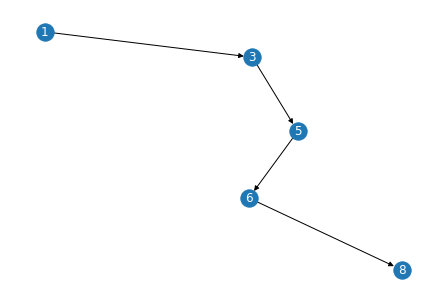

In [4]:
import networkx as nx
path = np.array(df[df['最早开工时间'] == df['最晚开工时间']].index)
G = nx.DiGraph()
G.add_nodes_from(set(range(1, n+1)) - {2, 4, 7})
G.add_edges_from(path)
nx.draw_spring(G, with_labels=True, font_color='w')

#### 3. 用 0-1 规划模型求关键路线
把关键路线看成最长路，则可以按照求最短路的方法 (将求极小改为求极大) 求出关键路线

设 $x_{ij}$ 为 0-1 变量，当作业 $(i,j)$ 位于关键路线上取 1，否则取 0。数学规划问题可写为：
$$
\begin{align*}
&\max\sum\limits_{\left(i,j\right)\in A}t_{ij}x_{ij},\\
&{\rm s.t.}
	\begin{cases}
	\sum\limits_{j:\left(1,j\right)\in A}x_{1j}=1,\\
	\sum\limits_{j:\left(i,j\right)\in A}x_{ij}-\sum\limits_{k:\left(k,i\right)\in A}x_{ki}=0,\quad i\neq 1,n,\\
	\sum\limits_{k:\left(k,n\right)\in A}x_{kn}=1,\\
	x_{ij}=0\text{或}1,\quad (i,j)\in A.
    \end{cases}
\end{align*}
$$

In [5]:
import cvxpy as cp
import numpy as np

n = 8
x = cp.Variable((n,n), boolean=True)
fun = 0
for k in range(len(L)):
    i, j, t = L[k][0]-1, L[k][1]-1, L[k][2]
    fun += t*x[i,j]
obj = cp.Maximize(fun)
out = [l[1]-1 for l in L if l[0] == 1]
inn = [l[0]-1 for l in L if l[1] == n]
cons = [
    cp.sum(x[0, out]) == 1,
    cp.sum(x[inn, n-1]) == 1,
]
for k in range(2, n):   # 不妨用 k表示自然序列 (1,2,...,n)的循环变量，而用 i表示机器序列的循环变量
    out = [l[1]-1 for l in L if l[0] == k]
    inn = [l[0]-1 for l in L if l[1] == k]
    cons.append(cp.sum(x[k-1, out]) - cp.sum(x[inn, k-1]) == 0)
prob = cp.Problem(obj, cons)
prob.solve(solver='GUROBI')
ni, nj = np.nonzero(x.value)
print("关键路径的端点为：", ni+1, nj+1, sep='\n')
print("总工期：", prob.value)

关键路径的端点为：
[1 3 5 6]
[3 5 6 8]
总工期： 51.0


### 6.7.4 关键路线与计划网络的优化
#### 赶工问题
需要压缩关键路径来减少最短工期

设 $m_{ij}$ 是能够完成作业 $(i,j)$ 的最短时间，$y_{ij}$ 是作业 $(i,j)$ 减少的时间 (决策变量)，$c_{ij}$ 是作业 $(i,j)$ 缩短一个单位时间增加的费用，$d$ 为要求完成的时间，则相应的数学规划问题为：
$$
\begin{align*}
&\min\sum\limits_{(i,j)\in A}c_{ij}y_{ij},\\
&{\rm s.t.}
	\begin{cases}
	x_j-x_i\geq t_{ij}-y_{ij},\quad (i,j)\in A,\\
	x_n - x_1\leq d,\\
	0\leq y_{ij}\leq t_{ij}-m_{ij},\quad (i,j)\in A.
	\end{cases}
\end{align*}
$$

In [6]:
L = [(1,2,5,5,0), (1,3,10,8,700), (1,4,11,8,400), (2,5,4,3,450), (3,4,4,4,0),
    (3,5,0,0,0), (4,6,15,15,0), (5,6,21,16,600), (5,7,25,22,300),
    (5,8,35,30,500), (6,7,0,0,0), (6,8,20,16,500), (7,8,15,12,400)] # (i,j,t,m,c)
d = 49
x = cp.Variable(8, nonneg=True)
y = cp.Variable((8,8), integer=True)
fun = 0
for k in range(len(L)):
    i, j, c = L[k][0]-1, L[k][1]-1, L[k][4]
    fun += c*y[i,j]
obj = cp.Minimize(fun)
cons = [
    x[-1] - x[0] <= d, 
    y >= 0
]
for k in range(len(L)):
    i, j, t, m = L[k][0]-1, L[k][1]-1, L[k][2], L[k][3]
    cons.append(x[j] - x[i] >= t - y[i,j])
    cons.append(y[i,j] <= t - m)
prob = cp.Problem(obj, cons)
prob.solve(solver='GLPK_MI')
print("最优值为：", prob.value)
print("x 的取值为：\n", x.value)
print("y 的取值为：\n", y.value)
ni, nj = np.nonzero(y.value)
print("压缩工期的作业为：", ni+1, nj+1, sep='\n')

最优值为： 1200.0
x 的取值为：
 [-0.  5.  9. 13.  9. 30. 34. 49.]
y 的取值为：
 [[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
压缩工期的作业为：
[1 6]
[3 8]


#### 求关键路径、各作业的最早开工时间和最迟开工时间
递推式需更改为
$$
\begin{align*}
&z_n=x_n,\quad n=8,\\
&z_i=\min_j\left\{z_j-(t_{ij}-y_{ij})\right\},\quad i=n-1,\cdots,1,\ (i,j)\in A,\\
\end{align*}
$$
$$
\begin{align*}
{\rm es}_{ij}&=x_i,\quad(i,j)\in A,\\
{\rm lf}_{ij}&=z_j,\quad(i,j)\in A,\\
{\rm ls}_{ij}&=z_j-(t_{ij}-y_{ij}),\quad(i,j)\in A,\\
{\rm ef}_{ij}&=x_i+(t_{ij}-y_{ij}),\quad(i,j)\in A.
\end{align*}
$$

In [7]:
n = 8
xx, yy = x.value, y.value

xx = x.value
z = np.zeros(n)
z[-1] = xx[-1]
for i in range(n-1, 0, -1):
    z[i-1] = min(z[l[1]-1] - (l[2] - yy[l[0]-1, l[1]-1]) for l in L if l[0] == i)
z

array([ 0.,  5.,  9., 15.,  9., 30., 34., 49.])

In [8]:
es, lf, ls, ef = [], [], [], []
for k in range(len(L)):
    i, j, t = L[k][0]-1, L[k][1]-1, L[k][2]
    es.append([(i+1, j+1), xx[i]])
    lf.append([(i+1, j+1), z[j]])
    ls.append([(i+1, j+1), z[j] - (t - yy[i,j])])
    ef.append([(i+1, j+1), xx[i] + (t - yy[i,j])])

import pandas as pd

es, ls, ef, lf = np.array(es, dtype=object), np.array(ls, dtype=object), np.array(ef, dtype=object), np.array(lf, dtype=object)
data = np.vstack([es[:,1], ls[:,1], ef[:,1], lf[:,1]]).T
df = pd.DataFrame(data, index=es[:,0], columns=['最早开工时间', '最晚开工时间', '最早完工时间', '最晚完工时间'])
df

,最早开工时间,最晚开工时间,最早完工时间,最晚完工时间
"(1, 2)",-0.0,0.0,5.0,5.0
"(1, 3)",-0.0,0.0,9.0,9.0
"(1, 4)",-0.0,4.0,11.0,15.0
"(2, 5)",5.0,5.0,9.0,9.0
"(3, 4)",9.0,11.0,13.0,15.0
"(3, 5)",9.0,9.0,9.0,9.0
"(4, 6)",13.0,15.0,28.0,30.0
"(5, 6)",9.0,9.0,30.0,30.0
"(5, 7)",9.0,9.0,34.0,34.0
"(5, 8)",9.0,14.0,44.0,49.0


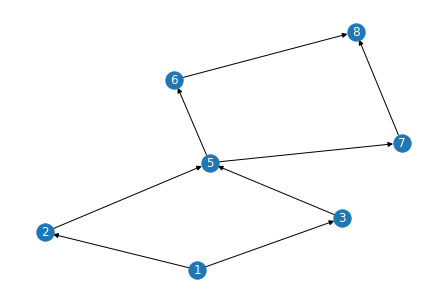

In [9]:
path = np.array(df[df['最早开工时间'] == df['最晚开工时间']].index)
G = nx.DiGraph()
G.add_nodes_from(set(range(1, n+1)) - {4})
G.add_edges_from(path)
nx.draw_spring(G, with_labels=True, font_color='w')

### 6.7.5 完成作业期望和实现事件的概率
对完成一项作业可以给出 3 个时间上的估计值：最乐观的估计值 $a$，最悲观的估计值 $b$，最可能的估计值 $e$

设 $t_{ij}$ 是完成作业 $(i,j)$ 的实际时间，通常用下面的方法计算其数学期望和方差：
$$
E(t_{ij})=\dfrac{a_{ij}+4e_{ij}+b_{ij}}{6}
$$
$$
{\rm Var}(t_{ij})=\dfrac{\left(b_{ij}-a_{ij}\right)^2}{36}
$$
设 $T$ 为实际工期，即
$$
T=\sum\limits_{(i,j)\in {\text 关键路径}}t_{ij}
$$
由中心极限定理，可以假设 $T$ 服从正态分布，并且期望值和方差满足
$$
\overline T=E(T)=\sum\limits_{(i,j)\in {\text 关键路径}}E\left(t_{ij}\right)
$$
$$
S^2={\rm Var}(T)=\sum\limits_{(i,j)\in {\text 关键路径}}{\rm Var}\left(t_{ij}\right)
$$
设规定的工期为 $d$，则在规定的工期内完成整个项目的概率为
$$
P\{T\leq d\}=\Phi\left(\dfrac{d-\overline T}{S} \right)
$$
其中 $\Phi(x)$ 为标准正态分布的分布函数

In [10]:
L = np.array([(1,2,3,5,7),(1,3,8,9,16),(1,4,8,11,14),(2,5,3,4,5),
    (3,4,2,4,6),(3,5,0,0,0),(4,6,8,16,18),(5,6,18,20,28),(5,7,18,25,32),
    (5,8,26,33,52),(6,7,0,0,0),(6,8,11,21,25),(7,8,12,15,18)])  # i, j, a, m, b

aa, mm, bb = L[:,2], L[:,3], L[:,4]
Et = (aa + 4*mm + bb)/6
Vt = (bb - aa)**2/36
Et, Vt

(array([ 5., 10., 11.,  4.,  4.,  0., 15., 21., 25., 35.,  0., 20., 15.]),
 array([ 0.44444444,  1.77777778,  1.        ,  0.11111111,  0.44444444,
         0.        ,  2.77777778,  2.77777778,  5.44444444, 18.77777778,
         0.        ,  5.44444444,  1.        ]))

In [11]:
n = 8
x = cp.Variable((n,n), boolean=True)
fun = 0
for k in range(len(L)):
    i, j = L[k][0]-1, L[k][1]-1
    fun += Et[k]*x[i,j]
obj = cp.Maximize(fun)
out = [l[1]-1 for l in L if l[0] == 1]
inn = [l[0]-1 for l in L if l[1] == n]
cons = [
    cp.sum(x[0, out]) == 1,
    cp.sum(x[inn, n-1]) == 1,
]
for k in range(2, n):   # 不妨用 k表示自然序列 (1,2,...,n)的循环变量，而用 i表示机器序列的循环变量
    out = [l[1]-1 for l in L if l[0] == k]
    inn = [l[0]-1 for l in L if l[1] == k]
    cons.append(cp.sum(x[k-1, out]) - cp.sum(x[inn, k-1]) == 0)
prob = cp.Problem(obj, cons)
prob.solve(solver='GUROBI')
print('最优值为：', prob.value); print('最优解为:\n', x.value)

最优值为： 51.0
最优解为:
 [[ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


In [12]:
from scipy.stats import norm

xx, f = x.value, prob.value
d = 52
s2 = 0
for k in range(len(L)):
    i, j = L[k][0]-1, L[k][1]-1
    s2 += xx[i,j]*Vt[k]
s = np.sqrt(s2)
p = norm.cdf(d, f, s)       # 累计分布函数
N = norm.ppf(0.95)*s + f    # cdf的逆
print('标准差s:\t\t', s)
print('概率p:\t\t', p)
print('需要天数N：\t', N)

标准差s:		 3.1622776601683795
概率p:		 0.6240851829770754
需要天数N：	 56.201483878755575
